In [85]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import hydrogen as h2

# Gasoline Demand Analysis

Currently d3ploy determines the demand from an equation. Here we compute such equation.

Data from: https://www.eia.gov/electricity/monthly/current_month/epm.pdf

Text(0.5, 0, 'Year')

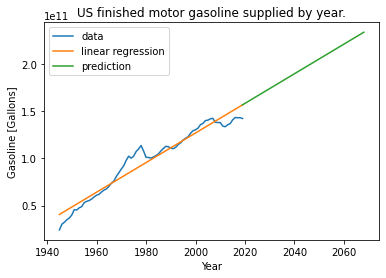

In [82]:
df = pd.read_csv ('supplied-motor-gasoline.csv')

# To retrieve the data as lists
# date = df['date'].tolist()
# volume = df['finished-motor-gasoline-supplied(thousand-barrels)'].tolist()  # [thousand-barrels]

date = df.iloc[:, :1].values
volume = df.iloc[:, 1].values  # [thousand-barrels]
volume = 1e3*volume  # [barrels]
volume = 42*volume  # [gallons]

# To convert data to dictionary
# zip(list(np.transpose(date)[0]), list(volume))
# data = dict(zip(list(np.transpose(date)[0]), list(volume)))
# data

lin = LinearRegression() 
lin.fit(date, volume)

end = 50
future = np.arange(end).reshape(end, 1) + date[-1]

plt.plot(date, volume, label='data')
plt.plot(date, lin.predict(date), label='linear regression')
plt.plot(future, lin.predict(future), label='prediction')
plt.legend(loc="upper left")
plt.title('US finished motor gasoline supplied by year.')
plt.ylabel('Gasoline [Gallons]')
plt.xlabel('Year')
# plt.savefig("fuel-demand", dpi=300, bbox_inches="tight")

## Hydrogen Production meets fuel demand over time

Deployment of new HTGRs that produce only Hydrogen.

Chosen HTGR: **GT-MHR**.

P = 600 MW$_{th}$

T$_{o}$ = 850 $^\circ$C

https://www-pub.iaea.org/MTCD/Publications/PDF/TE_1674_CD_web.pdf

The production meets the demand in year:  2168


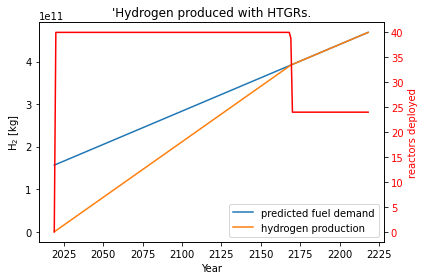

In [14]:
Pth = 600
pr = h2.hte1_prod_rate(Pth, 850)[1]  # [kg/h]
pr *= 365*24  # [kg/y]

end = 200
future = np.arange(end).reshape(end, 1) + date[-1]
fuel_demand = lin.predict(future)

rdr = 40*np.ones(end)  # reactor deployment rate
rdr[0] = 0
rdc = np.cumsum(rdr)  # reactor deployment cumulative

hydrogen = pr*rdc

for t in range(end):
    if hydrogen[t] < fuel_demand[t]:
        tintersect = t+future[0]
    else:
        hydrogen[t] = np.ceil(fuel_demand[t])
        rdc[t] = np.ceil(fuel_demand[t])/pr
        rdr[t] = rdc[t]-rdc[t-1]

print("The production meets the demand in year: ", tintersect[0])

fig, ax1 = plt.subplots()
ax1.plot(future, fuel_demand, label='predicted fuel demand')
ax1.plot(future, hydrogen, label='hydrogen production')
ax1.legend(loc="lower right")
ax1.set_title("'Hydrogen produced with HTGRs.", color="black")
ax1.set_ylabel('H$_2$ [kg]', color="black")
ax1.set_xlabel('Year')
ax2 = ax1.twinx()
ax2.plot(future, rdr, color='red')
ax2.set_ylabel('reactors deployed', color='red')
ax2.tick_params(axis='y', labelcolor='red')
fig.tight_layout()

## CO$_2$ savings

Burning a gallon of gasoline produces 19.64 lbs of CO$_2$.
For each kg-H_2 we are saving 19.64 lbs of CO$_2$.

Text(0.5, 0, 'Year')

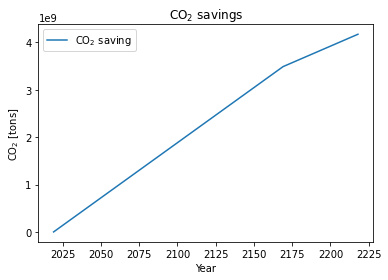

In [39]:
carbon = hydrogen*19.64  # [lbs]
carbon *= 0.453592  # [kg]
carbon /= 1000  # [metric tons]

plt.plot(future, carbon, label='CO$_2$ saving')
plt.legend(loc="upper left")
plt.title('CO$_2$ savings')
plt.ylabel('CO$_2$ [tons]')
plt.xlabel('Year')

## Future Work: D3ploy

D3ploy should be able to carry out this analysis on its own, but currently takes a function of time as the demand. If we can set this data as the demand in the initial years, then we wouldn't need the previous analysis.

D3ploy uses dictionaries. Retrieve the data and build a dictionary.

In [6]:
data = pd.read_csv('supplied-motor-gasoline.csv', header=0, index_col=0, squeeze=True).to_dict()

scaling = 42 * 1e3
total = {key: scaling * data[key] for key, values in data.items()}
print(total)

{1945: 24332406000.0, 1946: 30345504000.0, 1947: 32483136000.0, 1948: 35051100000.0, 1949: 36948282000.0, 1950: 40100466000.0, 1951: 45761772000.0, 1952: 45401580000.0, 1953: 47672646000.0, 1954: 48956334000.0, 1955: 53090688000.0, 1956: 54535992000.0, 1957: 55420554000.0, 1958: 56885262000.0, 1959: 59171784000.0, 1960: 61011552000.0, 1961: 61977132000.0, 1962: 64369536000.0, 1963: 66441732000.0, 1964: 67676616000.0, 1965: 70404768000.0, 1966: 73707144000.0, 1967: 76010886000.0, 1968: 80865834000.0, 1969: 84713790000.0, 1970: 88676658000.0, 1971: 92201256000.0, 1972: 98018676000.0, 1973: 102318552000.0, 1974: 100219392000.0, 1975: 102321576000.0, 1976: 107261028000.0, 1977: 110020680000.0, 1978: 113622936000.0, 1979: 107838066000.0, 1980: 101125374000.0, 1981: 100986816000.0, 1982: 100246608000.0, 1983: 101517528000.0, 1984: 102877362000.0, 1985: 104721162000.0, 1986: 107832270000.0, 1987: 110463738000.0, 1988: 112776132000.0, 1989: 112336140000.0, 1990: 110911164000.0, 1991: 110184648

## Analysis for different types of reactors and hydrogen production methods

**LWR** fleet Data:

Installed capacity (2019): 99.39 million kW [1].

96 reactors [2].


HTGR Data: Data correspond to **GT-MHR**

P = 600 MW$_{th}$ [3]

T$_o$  = 850 $^\circ$C [3]

References:

[1] https://www.eia.gov/electricity/monthly/current_month/epm.pdf

[2] https://www.eia.gov/tools/faqs/faq.php?id=207&t=3

[3] https://www-pub.iaea.org/MTCD/Publications/PDF/TE_1674_CD_web.pdf

### Future work
* Add more reactor types, maybe MSR and FBR. Efficiency for those?

([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text major ticklabel objects>)

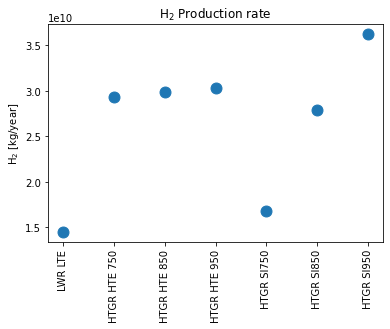

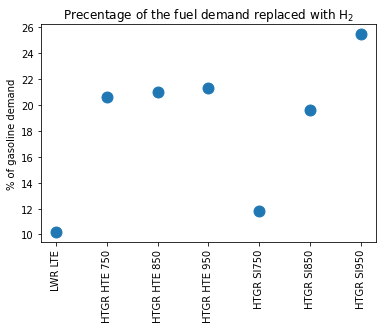

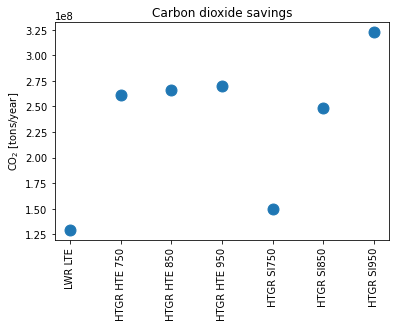

In [26]:
installed = 99.4e6  # [kW]
installed /= 1e3*0.33  # [MW-th]

carbon = hydrogen*19.64  # [lbs]
carbon *= 0.453592  # [kg]
carbon /= 1000  # [metric tons]

pr = []
fuel = []
carbon = []
xlab = []

pro = 365*24*h2.lte_prod_rate(installed, 0.33)[1]  # [kg/y]
pr.append(pro)
fuel.append(pr/volume[-1]*100)
carbon.append(pro*19.64*0.453592/1e3)  # [tons/y]
xlab.append('LWR LTE')

for tout in [750, 850, 950]:
    pro = 365*24*h2.hte1_prod_rate(installed, tout)[1]
    pr.append(pro)  # [kg/y]
    fuel.append(pro/volume[-1]*100)
    carbon.append(pro*19.64*0.453592/1e3)  # [tons/y]
    xlab.append('HTGR HTE '+ str(tout))

for tout in [750, 850, 950]:
    pro = 365*24*h2.si_prod_rate(installed, tout)[1]  # [kg/y]
    pr.append(pro)  # [kg/y]
    fuel.append(pro/volume[-1]*100)
    carbon.append(pro*19.64*0.453592/1e3)  # [tons/y]
    xlab.append('HTGR SI' + str(tout))
    
plt.figure(1)
plt.scatter(xlab, pr, marker='o', s=120)
plt.title('H$_2$ Production rate')
plt.ylabel('H$_2$ [kg/year]')
plt.xticks(rotation=90)

plt.figure(2)
plt.scatter(xlab, fuel, marker='o', s=120)
plt.title('Precentage of the fuel demand replaced with H$_2$')
plt.ylabel('% of gasoline demand')
plt.xticks(rotation=90)

plt.figure(3)
plt.scatter(xlab, carbon, marker='o', s=120)
plt.title('Carbon dioxide savings')
plt.ylabel('CO$_2$ [tons/year]')
plt.xticks(rotation=90)

# Off-peak hydrogen production

(duck curve)

Data from: 

https://www.eia.gov/beta/electricity/gridmonitor/dashboard/electric_overview/US48/US48

Get data for the solar energy generation over time. Make linear interpolation, and then throw that as all-solar is now all-new solar, all doesn't change? Maybe all follows a linear interpolation as well...
https://www.eia.gov/totalenergy/data/browser/index.php?tbl=T07.02A#/?f=A&start=1949&end=2019&charted=5-15-13
(https://www.eia.gov/totalenergy/data/annual/)

### Future work:
* By state ?
* Economics: Company (e.g. Exelon) cells H2 to transportation during off peak

/home/roberto/.local/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/home/roberto/.local/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/home/roberto/.local/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/home/roberto/.local/lib/python3.7/site-packages/dat

Text(0.5, 1.0, 'Total US electricity generated on 4/20/2020')

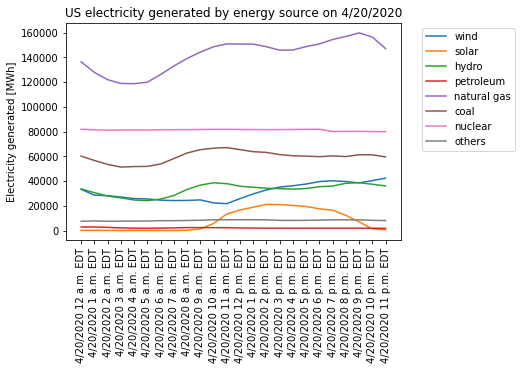

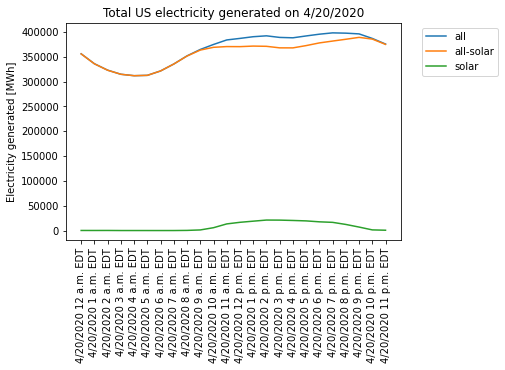

In [53]:
df = pd.read_csv ('electricity-generated.csv')
time = df['Timestamp (Hour Ending)'].tolist()
wind = df['Wind Generation (MWh)'].tolist()
solar = df['Solar Generation (MWh)'].tolist()
hydro = df['Hydro Generation (MWh)'].tolist()
petrol = df['Petroleum Generation (MWh)'].tolist()
natgas = df['Natural gas Generation (MWh)'].tolist()
coal = df['Coal Generation (MWh)'].tolist()
nuclear = df['Nuclear Generation (MWh)'].tolist()
other = df['Other Generation (MWh)'].tolist()

# choose date and time
sdate = '4/20/2020'
stime = '12 a.m. EDT'
edate = '4/21/2020'
etime = '12 a.m. EDT'

s = time.index(sdate+' '+stime)
e = time.index(edate+' '+etime)

ntime = time[s:e]
nwind = np.array(wind[s:e])
nsolar = np.array(solar[s:e])
nhydro = np.array(hydro[s:e])
npetrol = np.array(petrol[s:e])
nnatgas = np.array(natgas[s:e])
ncoal = np.array(coal[s:e])
nnuclear = np.array(nuclear[s:e])
nother = np.array(other[s:e])

plt.figure(1)
plt.plot(ntime, nwind, label='wind')
plt.plot(ntime, nsolar, label='solar')
plt.plot(ntime, nhydro, label='hydro')
plt.plot(ntime, npetrol, label='petroleum')
plt.plot(ntime, nnatgas, label='natural gas')
plt.plot(ntime, ncoal, label='coal')
plt.plot(ntime, nnuclear, label='nuclear')
plt.plot(ntime, nother, label='others')
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1.0), fancybox=True) 
plt.xticks(rotation=90)
plt.ylabel('Electricity generated [MWh]')
plt.title('US electricity generated by energy source on {0}'.format(sdate))

plt.figure(2)
alle = nwind + nsolar + nhydro + npetrol + nnatgas + ncoal + nnuclear + nother
plt.plot(ntime, alle, label='all')
plt.plot(ntime, alle-nsolar, label='all-solar')
plt.plot(ntime, nsolar, label='solar')
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1.0), fancybox=True) 
plt.xticks(rotation=90)
plt.ylabel('Electricity generated [MWh]')
plt.title('Total US electricity generated on {0}'.format(sdate))

Text(0.5, 1.0, 'Electricity net generation by sector by year.')

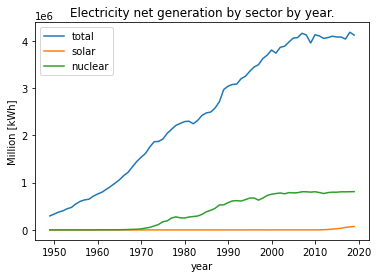

In [74]:
df = pd.read_csv ('electricity-year.csv')
time = df['Annual Total'].tolist()
solar = df["Electricity Net Generation From Solar, All Sectors (Million Kilowatthours)"].tolist()
nuclear = df["Electricity Net Generation From Nuclear Electric Power, All Sectors (Million Kilowatthours)"].tolist()
total = df["Electricity Net Generation Total (including from sources not shown), All Sectors (Million Kilowatthours)"].tolist()

for i in range(len(solar)):
    if solar[i] == 'Not Available':
        solar[i] = 0
    else:
        solar[i] = float(solar[i])

plt.plot(time, total, label='total')
plt.plot(time, solar, label='solar')
plt.plot(time, nuclear, label='nuclear')
plt.legend(loc='upper left')
plt.xlabel('year')
plt.ylabel('Million [kWh]')
plt.title('Electricity net generation by sector by year.')

4231509.584460607
307211.51719999686


Text(0.5, 1.0, 'Linear regresion on electricity net generation from solar.')

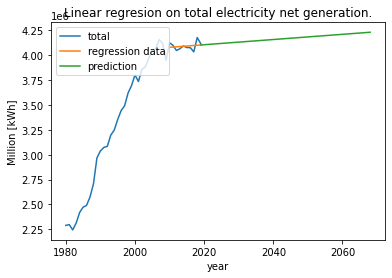

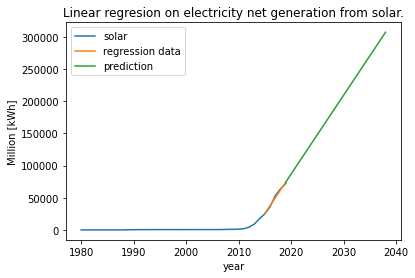

In [115]:
syear = 1980
ntime = time[time.index(syear):]
ntotal = total[time.index(syear):]
nsolar = solar[time.index(syear):]
nnuclear = nuclear[time.index(syear):]

tpyear = 2010
tptime = time[time.index(tpyear):]
tptime = np.array(tptime).reshape(len(tptime),1)
yt = total[time.index(tpyear):]
yt = np.array(yt)
lin = LinearRegression() 
lin.fit(tptime, yt)
pt = lin.predict(tptime)

end = 50
future = np.arange(end).reshape(end, 1) + tptime[-1]
ytf = lin.predict(future)
print(ytf[-1])

plt.figure(1)
plt.plot(ntime, ntotal, label='total')
plt.plot(tptime, pt, label='regression data')
plt.plot(future, ytf, label='prediction')
plt.legend(loc='upper left')
plt.xlabel('year')
plt.ylabel('Million [kWh]')
plt.title('Linear regresion on total electricity net generation.')

spyear = 2015
sptime = time[time.index(spyear):]
sptime = np.array(sptime).reshape(len(sptime),1)
ys = solar[time.index(spyear):]
ys = np.array(ys)
lin.fit(sptime, ys)
ps = lin.predict(sptime)

end = 20
future = np.arange(end).reshape(end, 1) + tptime[-1]
ysf = lin.predict(future)
print(ysf[-1])

plt.figure(2)
plt.plot(ntime, nsolar, label='solar')
plt.plot(sptime, ps, label='regression data')
plt.plot(future, ysf, label='prediction')
plt.legend(loc='upper left')
plt.xlabel('year')
plt.ylabel('Million [kWh]')
plt.title('Linear regresion on electricity net generation from solar.')


## Another

Look at data that Katy sent me, make economics analysis. Maybe carry out previous analysis by state.

## Another2

Serpent unit cell depletion calculation of PWR and HTGR:
- Fuel composition of PWR
- Fuel shape of PWR
- Fuel composition of HTGR
- Fuel shape of HTGR
